# Instacart Repurchase Analysis

### <b>Goal</b>: 
This project takes a look at Instacart customer shopping behavior. The goal is to identify what drives consumers to repurchase items so that a reccomendation system can be built to make "items you may like" suggestions on the app. 

### <b>Analysis</b>: 
I began by looking at the most popular items purchased and the aisles and departments most frequently purchased from. As a result of high dimensionality, categorical variables were turned into frequency counts to represent popularity and reduce dimensionality. After creating these new features, a decision tree classifier was created to determine behaviors most likely to lead to repurchases. The feature importance values from this tree indicated that only a few variables were contributing to the majority of variance. As a result, a Principle Component Analysis was performed to determine which variables to eliminate. The day of the week variables were completely useless and thus eliminated during subsequent analyses. The subset of variables was then run through a decision tree model again to see if the results changed.

### <b>Conclusion</b>: 
I found that <b>93% of customers repurchased at least one item</b>. This means that many customers can benifit from a reccommendation system if we can determine what leads to these repurchases. <b>64% of the customers that ordered from the app more than 13 times from the app reordered items.</b> When that group of customers is makeing purchases from a moderately popular aisle, 72% of them repurchase that item. In short, customers that use the app frequently to purchase from popular aisles tend to be making a repurchase. 

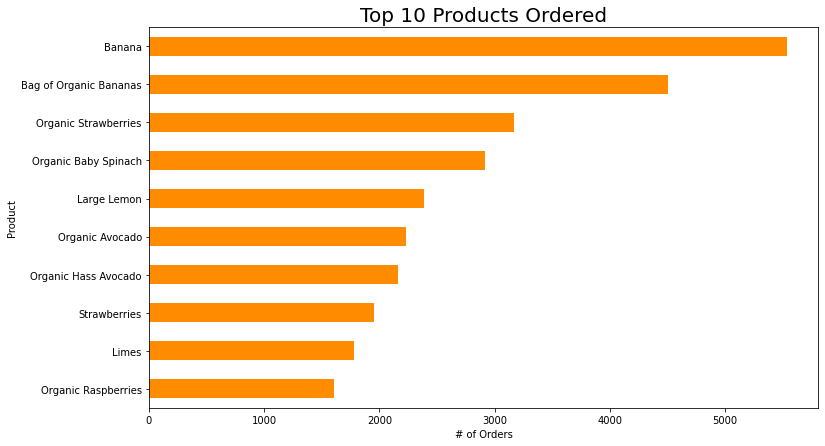
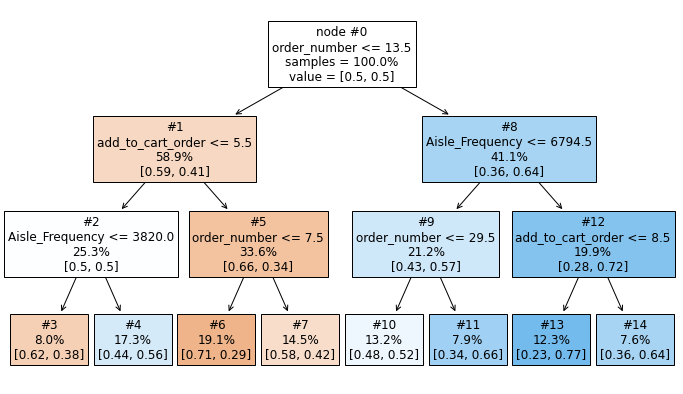
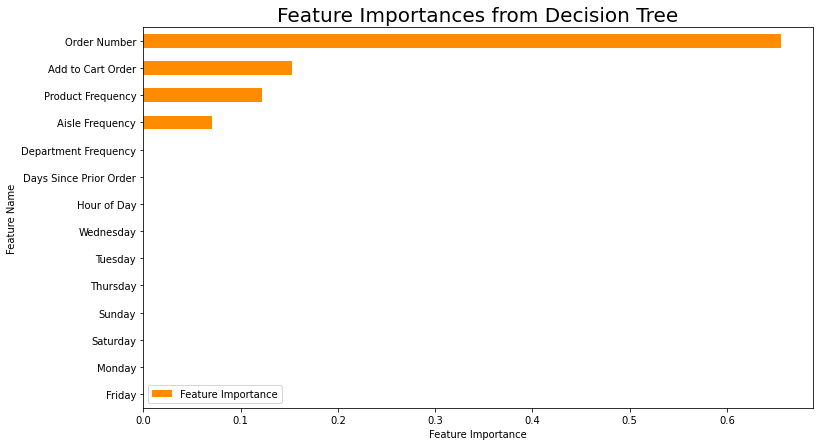

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sns.color_palette("YlOrBr", as_cmap=True)
plt.rcParams['figure.figsize'] = (12, 7)

In [21]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_products_train = pd.read_csv("order_products_train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

## Dataframe Previews

In [22]:
print(f"Aisle Dataframe Rows: {aisles.shape[0]}")
print(f"Aisle Dataframe Columns: {aisles.shape[1]}")
aisles.head()

Aisle Dataframe Rows: 134
Aisle Dataframe Columns: 2


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [23]:
print(f"Department Dataframe Rows: {departments.shape[0]}")
print(f"Department Dataframe Columns: {departments.shape[1]}")
departments.head()

Department Dataframe Rows: 21
Department Dataframe Columns: 2


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [24]:
print(f"Orders Dataframe Rows: {orders.shape[0]}")
print(f"Orders Dataframe Columns: {orders.shape[1]}")
orders.head()

Orders Dataframe Rows: 38748
Orders Dataframe Columns: 7


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,525192,7,train,21,2,11,6
1,880375,8,train,4,1,14,10
2,519514,49,train,9,4,12,2
3,39325,55,train,8,2,18,30
4,13318,56,train,13,1,9,6


In [25]:
print(f"Products Dataframe Rows: {products.shape[0]}")
print(f"Products Dataframe Columns: {products.shape[1]}")
products.head()

Products Dataframe Rows: 28578
Products Dataframe Columns: 4


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,3,Robust Golden Unsweetened Oolong Tea,94,7
2,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
3,8,Cut Russet Potatoes Steam N' Mash,116,1
4,9,Light Strawberry Blueberry Yogurt,120,16


In [26]:
print(f"Training Dataframe Rows: {order_products_train.shape[0]}")
print(f"Training Dataframe Columns: {order_products_train.shape[1]}")
order_products_train.head()

Training Dataframe Rows: 408575
Training Dataframe Columns: 4


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [27]:
products = products.merge(aisles, on="aisle_id") \
                   .merge(departments, on="department_id")

products.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks
2,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks
3,449,Chips Ahoy! Chewy Cookies,61,19,cookies cakes,snacks
4,622,Fudge Brownies with English Walnuts,61,19,cookies cakes,snacks


In [28]:
order_products = order_products_train.merge(products, on="product_id").sort_values("order_id")
order_products

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1114,1,13176,6,0,Bag of Organic Bananas,24,4,fresh fruits,produce
5620,1,47209,7,0,Organic Hass Avocado,24,4,fresh fruits,produce
7780,1,22035,8,1,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs
1107,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
...,...,...,...,...,...,...,...,...,...
207051,999985,3376,14,1,Organic Whole Kernel Sweet Corn No Salt Added,81,15,canned jarred vegetables,canned goods
247385,999985,23484,24,0,Organic Pine Nuts,117,19,nuts seeds dried fruit,snacks
366565,999985,41437,26,0,Hearty Minestrone with Vegetables Soup,69,15,soup broth bouillon,canned goods
107833,999985,19446,13,0,Thick & Chunky Salsa,67,20,fresh dips tapenades,deli


## Sample Order

In [29]:
order_products[order_products["order_id"] == 1]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1114,1,13176,6,0,Bag of Organic Bananas,24,4,fresh fruits,produce
5620,1,47209,7,0,Organic Hass Avocado,24,4,fresh fruits,produce
7780,1,22035,8,1,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs
1107,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
51,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce
374,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce
2,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs


### 28578 Products

In [30]:
order_products["product_name"].nunique()

28578

### Top 10 Most Common Products

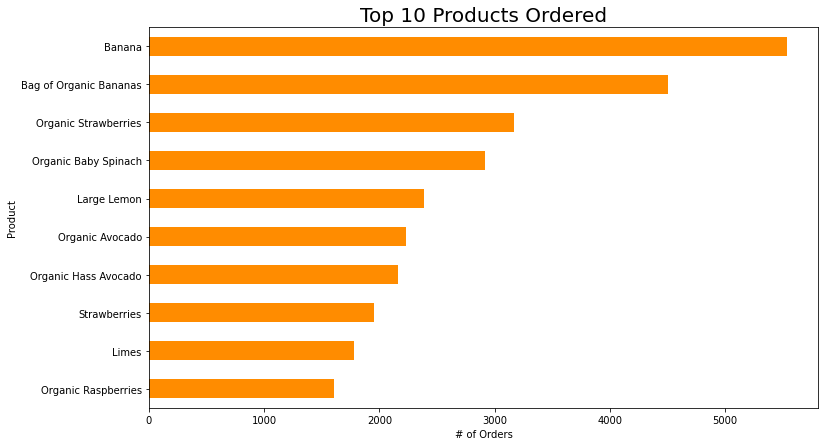

,product_name,count
0,Banana,5532
1,Bag of Organic Bananas,4506
2,Organic Strawberries,3164
3,Organic Baby Spinach,2917
4,Large Lemon,2389
5,Organic Avocado,2229
6,Organic Hass Avocado,2160
7,Strawberries,1953
8,Limes,1780
9,Organic Raspberries,1605


In [31]:
order_products["product_name"].value_counts().head(10).sort_values().plot(kind="barh", color="darkorange")
plt.title("Top 10 Products Ordered",fontsize=20)
plt.xlabel("# of Orders")
plt.ylabel("Product") 
plt.show()

display(order_products["product_name"].value_counts().reset_index().head(10))

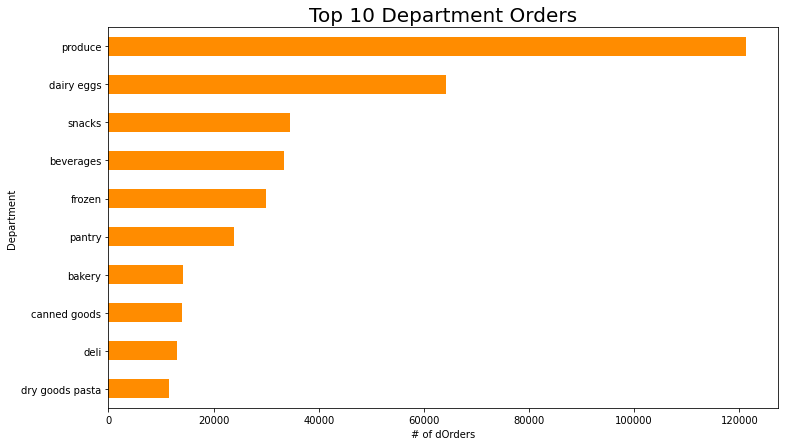

,department,count
0,produce,121300
1,dairy eggs,64163
2,snacks,34575
3,beverages,33467
4,frozen,29976
5,pantry,23879
6,bakery,14109
7,canned goods,13939
8,deli,12964
9,dry goods pasta,11470


In [32]:
order_products["department"].value_counts().head(10).sort_values().plot(kind="barh", color="darkorange")
plt.title("Top 10 Department Orders", fontsize=20)
plt.xlabel("# of dOrders")
plt.ylabel("Department") 
plt.show()

display(order_products["department"].value_counts().reset_index().head(10))

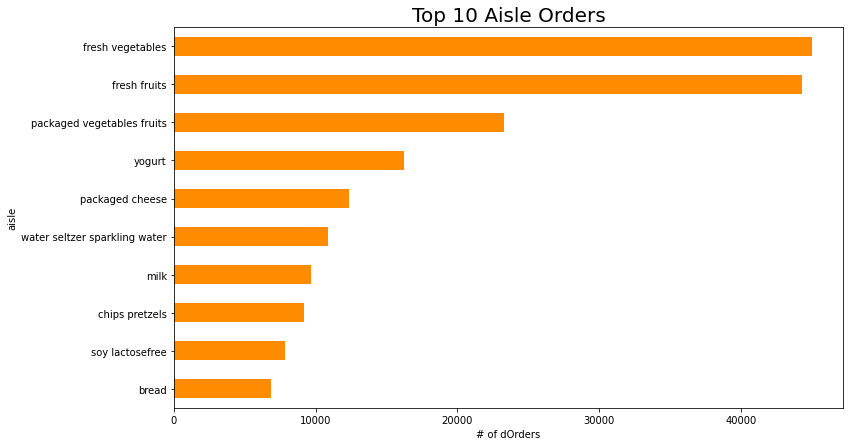

,aisle,count
0,fresh vegetables,44994
1,fresh fruits,44337
2,packaged vegetables fruits,23264
3,yogurt,16239
4,packaged cheese,12380
5,water seltzer sparkling water,10859
6,milk,9652
7,chips pretzels,9171
8,soy lactosefree,7841
9,bread,6851


In [33]:
order_products["aisle"].value_counts().head(10).sort_values().plot(kind="barh", color="darkorange")
plt.title("Top 10 Aisle Orders", fontsize=20)
plt.xlabel("# of dOrders")
plt.ylabel("aisle") 
plt.show()

display(order_products["aisle"].value_counts().reset_index().head(10))

## Data Cleaning

In [34]:
order_products.drop(["product_id", "department_id", "aisle_id"], axis=1, inplace=True)
order_products.head()

,order_id,add_to_cart_order,reordered,product_name,aisle,department
0,1,1,1,Bulgarian Yogurt,yogurt,dairy eggs
1114,1,6,0,Bag of Organic Bananas,fresh fruits,produce
5620,1,7,0,Organic Hass Avocado,fresh fruits,produce
7780,1,8,1,Organic Whole String Cheese,packaged cheese,dairy eggs
1107,1,5,1,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods


### Orders Dataframe

In [35]:
orders = orders.drop("eval_set", axis=1)
orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,525192,7,21,2,11,6
1,880375,8,4,1,14,10
2,519514,49,9,4,12,2
3,39325,55,8,2,18,30
4,13318,56,13,1,9,6


In [36]:
orders = orders[["user_id","order_id","order_number", "order_dow", "order_hour_of_day","days_since_prior_order"]].copy()
orders.sort_values("user_id")

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,7,525192,21,2,11,6
1,8,880375,4,1,14,10
19641,24,965160,19,0,16,0
19646,30,62370,9,2,13,22
19647,34,698604,6,4,13,30
...,...,...,...,...,...,...
36648,206181,681092,15,1,13,30
36649,206184,67174,5,1,15,30
19274,206186,160694,4,5,15,7
38747,206200,943915,24,6,19,6


### Map Day's of the Week to order_dow column

In [37]:
orders["order_dow"].value_counts()

order_dow
0    8048
1    5947
6    5477
5    5153
2    4800
4    4689
3    4634
Name: count, dtype: int64

In [38]:
dow = {0:"Sunday", 1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 5:"Friday", 6:"Saturday"}

orders["order_dow"] = orders["order_dow"].map(dow)
orders["order_dow"].value_counts()

order_dow
Sunday       8048
Monday       5947
Saturday     5477
Friday       5153
Tuesday      4800
Thursday     4689
Wednesday    4634
Name: count, dtype: int64

### Most Orders placed between 10am and 3pm

In [39]:
orders["order_hour_of_day"].value_counts()

order_hour_of_day
15    3362
14    3260
11    3175
16    3155
12    3118
13    3103
10    3087
17    2693
9     2691
18    2169
8     1848
19    1741
20    1144
7     1048
21     910
22     744
23     464
6      332
0      239
1      141
5      129
2       72
4       63
3       60
Name: count, dtype: int64

### 30 days is the most common lenth of days between orders

In [40]:
orders["days_since_prior_order"].value_counts().head()

days_since_prior_order
30    11957
7      2673
6      1886
8      1608
5      1560
Name: count, dtype: int64

Order Table contains User Id, Total Orders, Day of Week, Hour of Day, Days Since last order

In [41]:
orders.head()

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,7,525192,21,Tuesday,11,6
1,8,880375,4,Monday,14,10
2,49,519514,9,Thursday,12,2
3,55,39325,8,Tuesday,18,30
4,56,13318,13,Monday,9,6


In [42]:
full_orders = orders.merge(order_products, on="order_id").sort_values(["user_id","order_id","add_to_cart_order"])
full_orders.head()

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,aisle,department
5,7,525192,21,Tuesday,11,6,1,0,Panama Peach Antioxidant Infusion,refrigerated,beverages
2,7,525192,21,Tuesday,11,6,2,1,Antioxidant Infusions Beverage Malawi Mango,refrigerated,beverages
4,7,525192,21,Tuesday,11,6,3,1,Antioxidant Infusions Ipanema Pomegranate Beve...,refrigerated,beverages
8,7,525192,21,Tuesday,11,6,4,1,85% Lean Ground Beef,meat counter,meat seafood
1,7,525192,21,Tuesday,11,6,5,1,Raspberry Lemonade,refrigerated,beverages


In [43]:
re_order_cnts = full_orders.groupby("user_id")["reordered"].sum().reset_index().sort_values("reordered", ascending=False)
re_order_cnts

,user_id,reordered
34212,181991,71
31871,169647,63
23105,123044,56
27937,148812,54
15652,83836,53
...,...,...
12189,65115,0
35732,190261,0
12194,65143,0
28595,152277,0


### Only 2552 customers have 0 Reordered Items
### 93% of Customers Have Reorderd at least 1 item

In [44]:
re_order_cnts[re_order_cnts["reordered"] == 0]

,user_id,reordered
19058,101755,0
18753,100180,0
1790,9403,0
1825,9607,0
25815,137653,0
...,...,...
12189,65115,0
35732,190261,0
12194,65143,0
28595,152277,0


In [45]:
full_orders.head()

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,aisle,department
5,7,525192,21,Tuesday,11,6,1,0,Panama Peach Antioxidant Infusion,refrigerated,beverages
2,7,525192,21,Tuesday,11,6,2,1,Antioxidant Infusions Beverage Malawi Mango,refrigerated,beverages
4,7,525192,21,Tuesday,11,6,3,1,Antioxidant Infusions Ipanema Pomegranate Beve...,refrigerated,beverages
8,7,525192,21,Tuesday,11,6,4,1,85% Lean Ground Beef,meat counter,meat seafood
1,7,525192,21,Tuesday,11,6,5,1,Raspberry Lemonade,refrigerated,beverages


## Data Preprocessing: Encoding & Scailing

#### Step 1a: Reduce Dimensionailty - Product Name
* Replace names with frequency counts for a numerical representation of popularity.

In [46]:
full_orders["Product_Frequency"] = full_orders["product_name"].map(full_orders["product_name"].value_counts())
full_orders[["product_name", "Product_Frequency"]].sort_values("Product_Frequency", ascending=False).head()

,product_name,Product_Frequency
87051,Banana,5532
175206,Banana,5532
267625,Banana,5532
278793,Banana,5532
371243,Banana,5532


#### Step 1b: Reduce Dimensionality - Department
* Replace department with frequency counts for a numerical representation of popularity.

In [47]:
full_orders["Department_Frequency"] = full_orders["department"].map(full_orders["department"].value_counts())
full_orders[["department", "Department_Frequency"]].sort_values("Department_Frequency", ascending=False).head()

,department,Department_Frequency
272219,produce,121300
121830,produce,121300
378617,produce,121300
306610,produce,121300
306611,produce,121300


#### Step 1c: Encode Categorical Variables - Aisle
* Replace aisles with frequency counts for a numerical representation of popularity.

In [48]:
full_orders["Aisle_Frequency"] = full_orders["aisle"].map(full_orders["aisle"].value_counts())
full_orders[["aisle", "Aisle_Frequency"]].sort_values("Aisle_Frequency", ascending=False).head()

,aisle,Aisle_Frequency
263626,fresh vegetables,44994
368449,fresh vegetables,44994
51831,fresh vegetables,44994
215023,fresh vegetables,44994
51833,fresh vegetables,44994


#### Step 1d: Remove Original Categorical Variables

In [49]:
full_orders = full_orders.drop(["aisle","department","product_name","order_id", "user_id"], axis=1)
full_orders = full_orders[['order_number', 'order_hour_of_day','days_since_prior_order', 
                           'add_to_cart_order', 'reordered','Product_Frequency', 
                           'Department_Frequency', 'Aisle_Frequency', 'order_dow']].copy()
full_orders.head()

,order_number,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,Product_Frequency,Department_Frequency,Aisle_Frequency,order_dow
5,21,11,6,1,0,6,33467,6816,Tuesday
2,21,11,6,2,1,7,33467,6816,Tuesday
4,21,11,6,3,1,13,33467,6816,Tuesday
8,21,11,6,4,1,198,8943,905,Tuesday
1,21,11,6,5,1,62,33467,6816,Tuesday


In [50]:
full_orders.columns

Index(['order_number', 'order_hour_of_day', 'days_since_prior_order',
       'add_to_cart_order', 'reordered', 'Product_Frequency',
       'Department_Frequency', 'Aisle_Frequency', 'order_dow'],
      dtype='object')

#### Step 2: Split Data into train/test sets

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import tree, metrics


feature_cols1 = full_orders.drop("reordered", axis=1).columns

X = full_orders[feature_cols1].values
y = full_orders["reordered"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
print(f"Training Set Rows: {X_train.shape[0]}")
print(f"Test Set Rows: {X_test.shape[0]}")

Training Set Rows: 286002
Test Set Rows: 122573


#### Step 3: Data Preprocessing
* Scale Numeric Variables
* One Hot Encode Categorical Variables

In [52]:
categorical_features = [X.shape[1] - 1]
numerical_features = list(range(X.shape[1])[:-1])

# sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(),categorical_features),
        ('num', StandardScaler(), numerical_features)        
    ])


# Create a pipeline for preprocessing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the preprocessing pipeline on the training data
X_train_preprocessed = pipeline.fit_transform(X_train)

X_test_preprocessed = pipeline.transform(X_test)

In [53]:
feature_cols = pipeline.named_steps['preprocessor'].get_feature_names_out().tolist()
feature_cols[0] = "Friday"
feature_cols[1] = "Monday"
feature_cols[2] = "Saturday"
feature_cols[3] = "Sunday"
feature_cols[4] = "Thursday"
feature_cols[5] = "Tuesday" 
feature_cols[6] = "Wednesday"
feature_cols[7] = "Order Number" 
feature_cols[8] = "Hour of Day"
feature_cols[9] = "Days Since Prior Order"
feature_cols[10] = "Add to Cart Order"
feature_cols[11] = "Product Frequency"
feature_cols[12] = "Department Frequency"
feature_cols[13] = "Aisle Frequency"

In [54]:
feature_cols

['Friday',
 'Monday',
 'Saturday',
 'Sunday',
 'Thursday',
 'Tuesday',
 'Wednesday',
 'Order Number',
 'Hour of Day',
 'Days Since Prior Order',
 'Add to Cart Order',
 'Product Frequency',
 'Department Frequency',
 'Aisle Frequency']

## Decision Tree: Tree Plot
* Using decision tree as a preliminary step to understand the relationship between the features and reordered column.
* Which variables have the most impact on reorderd items?

[]

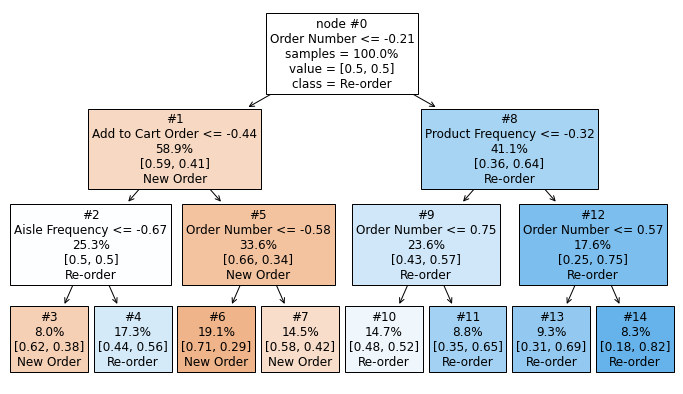

In [55]:
from sklearn import tree


# Train Decision Tree Model
clf = tree.DecisionTreeClassifier(max_depth=3, class_weight="balanced")
clf2 = clf.fit(X_train_preprocessed, y_train)

# Plot the Decision Tree
tree.plot_tree(clf2,
               feature_names=feature_cols,
               class_names=["New Order", "Re-order"],
               filled=True,
               precision=2,
               node_ids=True,
               fontsize=12,
               label="root", 
               proportion=True,
               impurity=False,)

plt.plot()

,Feature Importance
Order Number,0.655307
Add to Cart Order,0.152740
Product Frequency,0.121751
Aisle Frequency,0.070202
Friday,0.000000
Monday,0.000000
Saturday,0.000000
Sunday,0.000000
Thursday,0.000000
Tuesday,0.000000


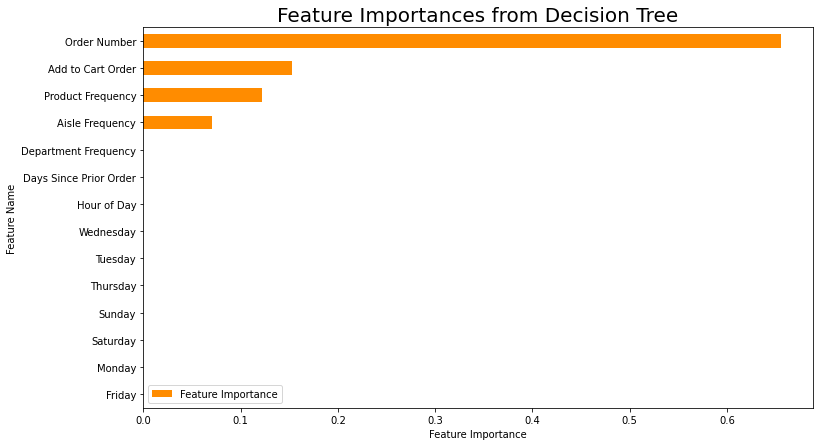

In [56]:
feature_importances = clf.feature_importances_

feature_names = feature_cols  # Replace with your actual feature names
feature_importance_map = dict(zip(feature_names, feature_importances))

f_importance = pd.DataFrame(feature_importance_map, index=range(len(feature_importance_map))).drop_duplicates() \
                                                                                             .T \
                                                                                             .rename(columns={0:"Feature Importance"}) \
                                                                                             .sort_values("Feature Importance") 
# Display Feature Importances Table
display(f_importance.sort_values("Feature Importance", ascending=False))

# Plot feature importances
f_importance.plot(kind="barh", color="darkorange")
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importances from Decision Tree', fontsize=20)
plt.show()

## Dimensionality Reduction: PCA (Principle Componenet Analysis)

In [1668]:
from sklearn.decomposition import PCA

num_components = 6 
# Assume X is your data matrix
pca = PCA(n_components=num_components)
X_train_pca = pca.fit(X_train_preprocessed)
X_test_pca = pca.fit(X_test_preprocessed)

### Elbow Method

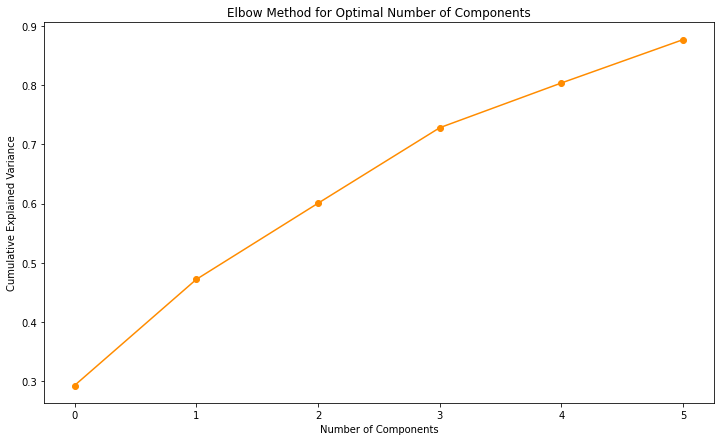

In [1681]:
cumulative_variance = np.cumsum(X_train_pca.explained_variance_ratio_)

# Plot the explained variance and look for the elbow
plt.plot(cumulative_variance, marker='o', color="darkorange")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for Optimal Number of Components')
plt.show()

### Scree Plot

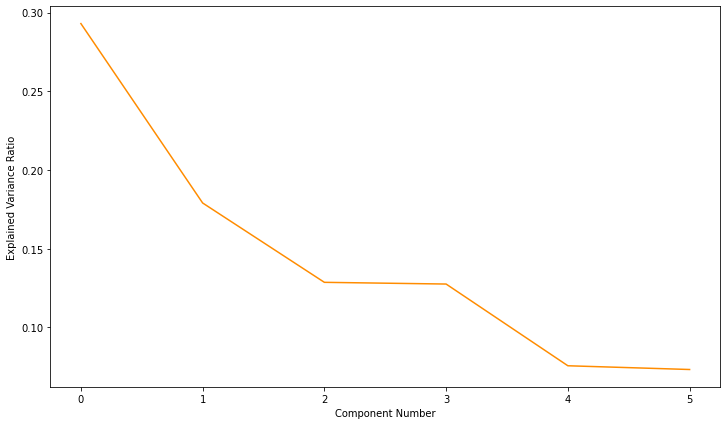

In [1682]:
plt.plot(X_train_pca.explained_variance_ratio_, color="darkorange")
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.show()

### Principle Component #1

,Loadings
Aisle Frequency,0.613057
Department Frequency,0.606863
Product Frequency,0.493279
Add to Cart Order,0.078856
Order Number,0.056683
Days Since Prior Order,0.054723
Sunday,0.009978
Thursday,0.003434
Wednesday,0.003269
Friday,0.001710


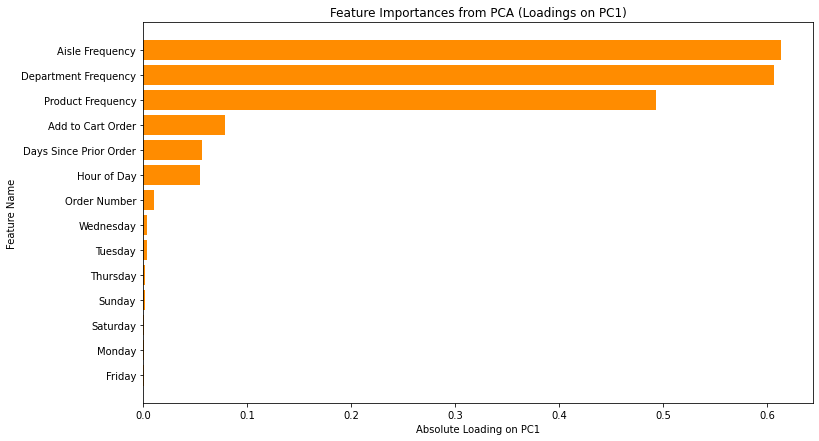

In [1683]:
# Get the absolute values of the loadings for each feature on the first principal component
feature_importances_pc1 = np.abs(X_train_pca.components_[0, :])

# Map feature names to their importance scores
feature_names = feature_cols  # Replace with your actual feature names
pc1_feature_importance_map = dict(zip(feature_cols, feature_importances_pc1))

# Print or visualize feature importances
display(pd.DataFrame(pc1_feature_importance_map, index=["Loadings"]).T.sort_values("Loadings", ascending=False))


# Plot feature importances
plt.barh(list(pc1_feature_importance_map.keys()), list(sorted(pc1_feature_importance_map.values())), color="darkorange")
plt.xlabel('Absolute Loading on PC1')
plt.ylabel('Feature Name')
plt.title('Feature Importances from PCA (Loadings on PC1)')

plt.show()

### Principle Component #2

,Loadings
Order Number,0.706592
Days Since Prior Order,0.700677
Aisle Frequency,0.048550
Department Frequency,0.045934
Hour of Day,0.045252
Product Frequency,0.037303
Add to Cart Order,0.031925
Monday,0.018510
Friday,0.012762
Sunday,0.011076


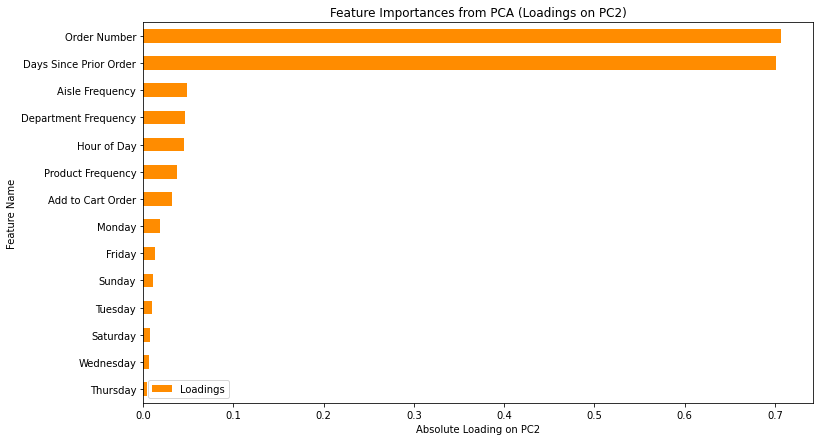

In [1684]:
# Get the absolute values of the loadings for each feature on the second principal component
feature_importances_pc2 = np.abs(X_train_pca.components_[1, :])

# Map feature names to their importance scores
feature_names = feature_cols  # Replace with your actual feature names
pc2_feature_importance_map = dict(zip(feature_cols, feature_importances_pc2))

# Print or visualize feature importances
#display(pd.DataFrame(pc2_feature_importance_map, index=["Loadings"]).T.sort_values("Loadings", ascending=False))
display(pd.DataFrame(pc2_feature_importance_map, index=["Loadings"]).T.sort_values("Loadings", ascending=False))


# Plot feature importances
pc2_df = pd.DataFrame(pc2_feature_importance_map, index=["Loadings"]).T.sort_values("Loadings", ascending=False)
pc2_df.sort_values("Loadings").plot(kind="barh", color="darkorange")
plt.xlabel('Absolute Loading on PC2')
plt.ylabel('Feature Name')
plt.title('Feature Importances from PCA (Loadings on PC2)')
plt.show()

### Principle Component # 3

,Loadings
Add to Cart Order,0.898670
Hour of Day,0.412990
Aisle Frequency,0.087757
Department Frequency,0.075407
Days Since Prior Order,0.071882
Product Frequency,0.052724
Sunday,0.014858
Order Number,0.012202
Thursday,0.008013
Wednesday,0.005175


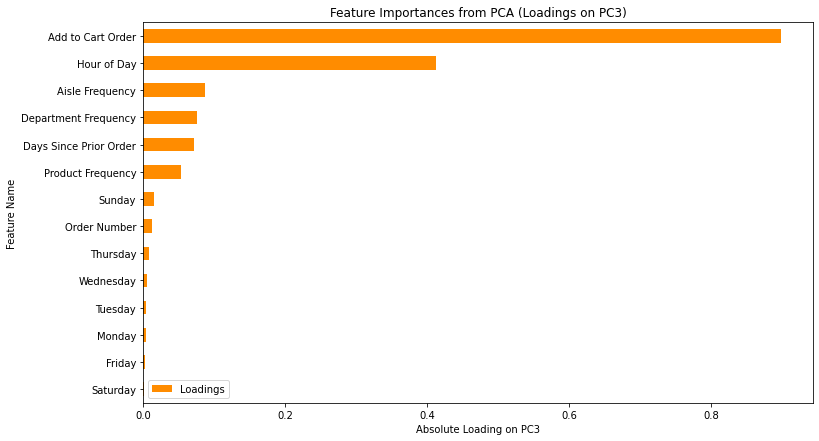

In [1685]:
# Get the absolute values of the loadings for each feature on the third principal component
feature_importances_pc3 = np.abs(X_train_pca.components_[2, :])

# Map feature names to their importance scores
feature_names = feature_cols  # Replace with your actual feature names
pc3_feature_importance_map = dict(zip(feature_cols, feature_importances_pc3))

# Print or visualize feature importances
display(pd.DataFrame(pc3_feature_importance_map, index=["Loadings"]).T.sort_values("Loadings", ascending=False))


# Plot feature importances
pc3_df = pd.DataFrame(pc3_feature_importance_map, index=["Loadings"]).T.sort_values("Loadings", ascending=False)
pc3_df.sort_values("Loadings").plot(kind="barh", color="darkorange")
plt.xlabel('Absolute Loading on PC3')
plt.ylabel('Feature Name')
plt.title('Feature Importances from PCA (Loadings on PC3)')
plt.show()

### Principle Component # 4

,Loadings
Hour of Day,0.908369
Add to Cart Order,0.411946
Aisle Frequency,0.040908
Days Since Prior Order,0.038001
Department Frequency,0.032061
Product Frequency,0.027878
Sunday,0.008806
Saturday,0.007029
Monday,0.006543
Friday,0.006297


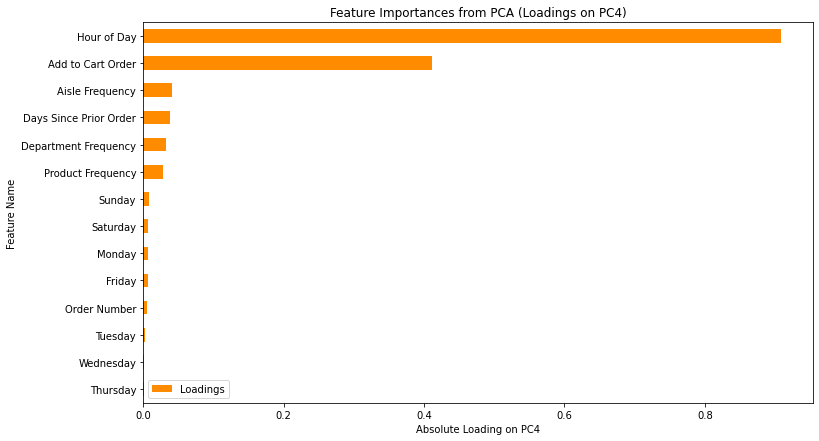

In [1686]:
# Get the absolute values of the loadings for each feature on the fourth principal component
feature_importances_pc4 = np.abs(X_train_pca.components_[3, :])

# Map feature names to their importance scores
feature_names = feature_cols  # Replace with your actual feature names
pc4_feature_importance_map = dict(zip(feature_cols, feature_importances_pc4))

# Print or visualize feature importances
display(pd.DataFrame(pc4_feature_importance_map, index=["Loadings"]).T.sort_values("Loadings", ascending=False))


# Plot feature importances
pc3_df = pd.DataFrame(pc4_feature_importance_map, index=["Loadings"]).T.sort_values("Loadings", ascending=False)
pc3_df.sort_values("Loadings").plot(kind="barh", color="darkorange")
plt.xlabel('Absolute Loading on PC4')
plt.ylabel('Feature Name')
plt.title('Feature Importances from PCA (Loadings on PC4)')
plt.show()

### Principle Component # 5

,Loadings
Days Since Prior Order,0.687759
Order Number,0.685394
Product Frequency,0.201853
Department Frequency,0.088670
Aisle Frequency,0.078549
Hour of Day,0.045408
Add to Cart Order,0.016394
Wednesday,0.005564
Sunday,0.004946
Monday,0.004854


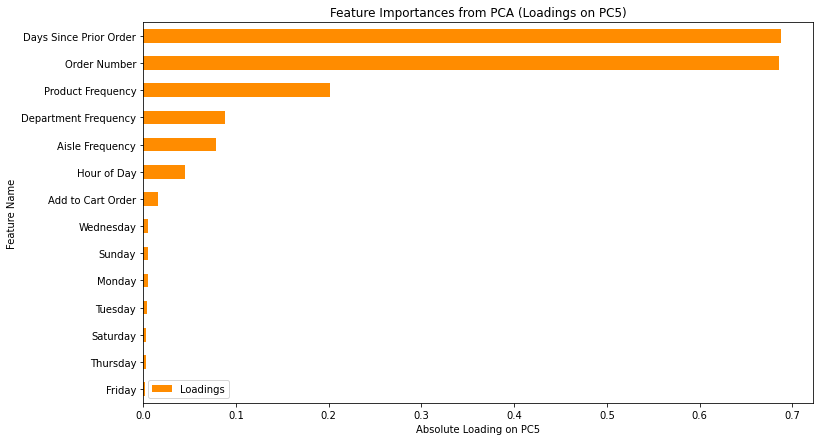

In [1692]:
# Get the absolute values of the loadings for each feature on the fifth principal component
feature_importances_pc5 = np.abs(X_train_pca.components_[4, :])

# Map feature names to their importance scores
feature_names = feature_cols 
pc5_feature_importance_map = dict(zip(feature_cols, feature_importances_pc5))

# Print or visualize feature importances
display(pd.DataFrame(pc5_feature_importance_map, index=["Loadings"]).T.sort_values("Loadings", ascending=False))


# Plot feature importances
pc3_df = pd.DataFrame(pc5_feature_importance_map, index=["Loadings"]).T.sort_values("Loadings", ascending=False)
pc3_df.sort_values("Loadings").plot(kind="barh", color="darkorange")
plt.xlabel('Absolute Loading on PC5')
plt.ylabel('Feature Name')
plt.title('Feature Importances from PCA (Loadings on PC5)')
plt.show()

### Principle Component # 6

,Loadings
Product Frequency,0.842095
Department Frequency,0.365841
Aisle Frequency,0.298960
Order Number,0.165045
Days Since Prior Order,0.160596
Add to Cart Order,0.120624
Hour of Day,0.008258
Saturday,0.001999
Thursday,0.001456
Sunday,0.001357


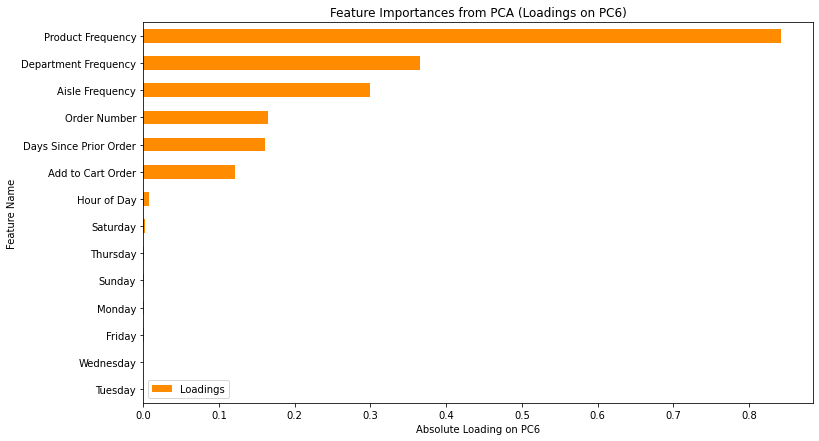

In [1687]:
# Get the absolute values of the loadings for each feature on the sixth principal component
feature_importances_pc6 = np.abs(X_train_pca.components_[5, :])

# Map feature names to their importance scores
feature_names = feature_cols 
pc6_feature_importance_map = dict(zip(feature_cols, feature_importances_pc6))

# Print or visualize feature importances
display(pd.DataFrame(pc6_feature_importance_map, index=["Loadings"]).T.sort_values("Loadings", ascending=False))


# Plot feature importances
pc3_df = pd.DataFrame(pc6_feature_importance_map, index=["Loadings"]).T.sort_values("Loadings", ascending=False)
pc3_df.sort_values("Loadings").plot(kind="barh", color="darkorange")
plt.xlabel('Absolute Loading on PC6')
plt.ylabel('Feature Name')
plt.title('Feature Importances from PCA (Loadings on PC6)')
plt.show()

In [1693]:
## Decision Tree w/ Important features
full_orders

,order_number,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,Product_Frequency,Department_Frequency,Aisle_Frequency,order_dow
5,21,11,6,1,0,6,33467,6816,Tuesday
2,21,11,6,2,1,7,33467,6816,Tuesday
4,21,11,6,3,1,13,33467,6816,Tuesday
8,21,11,6,4,1,198,8943,905,Tuesday
1,21,11,6,5,1,62,33467,6816,Tuesday
...,...,...,...,...,...,...,...,...,...
390579,14,14,30,4,0,17,10490,1358,Saturday
390577,14,14,30,5,0,18,34575,3376,Saturday
390572,14,14,30,6,0,14,29976,6773,Saturday
390575,14,14,30,7,0,29,14109,6851,Saturday


In [1694]:
feature_cols2 = full_orders[["order_hour_of_day","add_to_cart_order","days_since_prior_order","order_number",
                             "Aisle_Frequency", "Department_Frequency"]].columns

X = full_orders[feature_cols2].values
y = full_orders["reordered"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
print(f"Training Set Rows: {X_train.shape[0]}")
print(f"Test Set Rows: {X_test.shape[0]}")

Training Set Rows: 286002
Test Set Rows: 122573


In [1702]:
categorical_features = [X.shape[1] - 1]
numerical_features = list(range(X.shape[1]))

# sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)        
    ])


# Create a pipeline for preprocessing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the preprocessing pipeline on the training data
X_train_preprocessed = pipeline.fit_transform(X_train)

X_test_preprocessed = pipeline.transform(X_test)

In [1706]:
feature_cols = pipeline.named_steps['preprocessor'].get_feature_names_out().tolist()
feature_cols[0] = "Hour of Day"
feature_cols[1] = "Add to Cart Order"
feature_cols[2] = "Days Since Prior Order"
feature_cols[3] = "Order Number"
feature_cols[4] = "Aisle Frequency"
feature_cols[5] = "Department Frequency"

feature_cols

['Hour of Day',
 'Add to Cart Order',
 'Days Since Prior Order',
 'Order Number',
 'Aisle Frequency',
 'Department Frequency']

[]

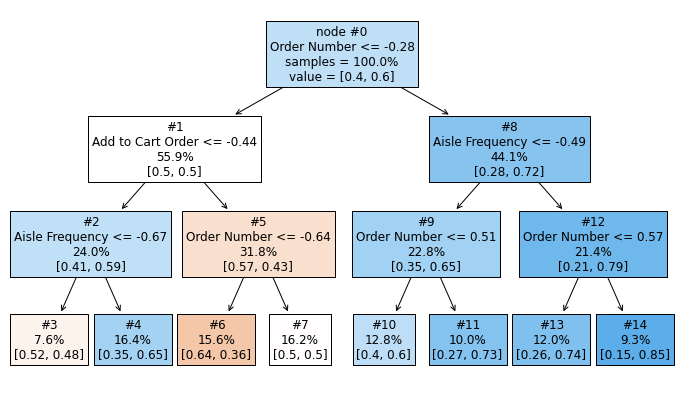

In [1707]:
# Train Decision Tree Model
clf = tree.DecisionTreeClassifier(max_depth=3)
clf2 = clf.fit(X_train_preprocessed, y_train)

# Plot the Decision Tree
tree.plot_tree(clf2,
               feature_names=feature_cols,
               filled=True,
               precision=2,
               node_ids=True,
               fontsize=12,
               label="root", 
               proportion=True,
               impurity=False,)

plt.plot()

## Decision Tree w/ Unscaled Data

In [1777]:
model_data = full_orders[["order_hour_of_day","add_to_cart_order","days_since_prior_order",
                          "order_number", "Aisle_Frequency", "Department_Frequency", "reordered"]].copy()

X = model_data.drop("reordered", axis=1)
y = model_data["reordered"]
feature_cols = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

[]

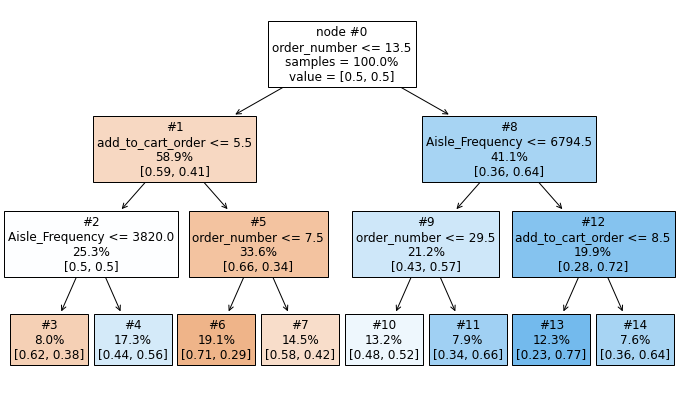

In [1778]:
clf = tree.DecisionTreeClassifier(max_depth=3, class_weight="balanced")

clf2 = clf.fit(X_train, y_train)


# Plot the Decision Tree
tree.plot_tree(clf2,
               feature_names=feature_cols,
               filled=True,
               precision=2,
               node_ids=True,
               fontsize=12,
               label="root", 
               proportion=True,
               impurity=False,)

plt.plot()

In [ ]:
Decision Tree Notes:

# Most Reorders
- Customer has 14 or more orders (High Volume of Orders)
- Customer purchasing from popularly shopped Aisles


## Decision Tree w/ Unscaled Data + Product Frequency Counts

In [1779]:
model_data = full_orders[["order_hour_of_day","add_to_cart_order","days_since_prior_order",
                          "order_number", "Aisle_Frequency", "Department_Frequency", "reordered",
                          "Product_Frequency"]].copy()

X = model_data.drop("reordered", axis=1)
y = model_data["reordered"]
feature_cols = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

[]

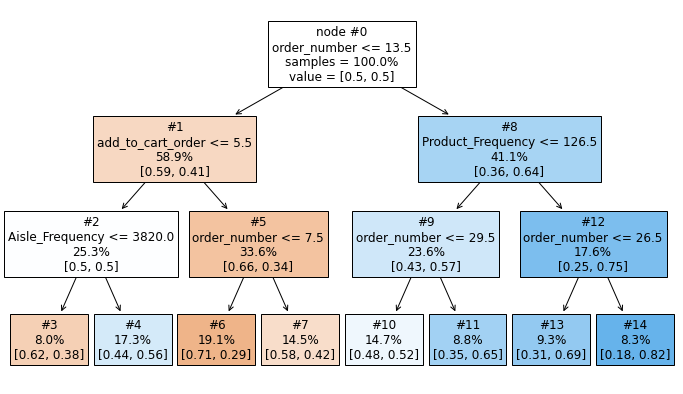

In [1780]:
clf = tree.DecisionTreeClassifier(max_depth=3, class_weight="balanced")

clf2 = clf.fit(X_train, y_train)


# Plot the Decision Tree
tree.plot_tree(clf2,
               feature_names=feature_cols,
               filled=True,
               precision=2,
               node_ids=True,
               fontsize=12,
               label="root", 
               proportion=True,
               impurity=False,)

plt.plot()

In [ ]:
Decision Tree Notes:

# Most Reorders
- Customer has 14 or more orders (High Volume of Orders)
- Customer purchasing frequently bought item (127 or total purchases)
** 107471 items purchased were Reordered under this criteria or 26% 


# EXTRA ANALYSIS

In [ ]:
full_orders.select_dtypes(include=["int","float64"]).corr()

,order_number,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,Product_Frequency,Department_Frequency,Aisle_Frequency
order_number,1.000000,-0.024481,-0.405423,0.015724,0.224552,0.029270,0.031242,0.028011
order_hour_of_day,-0.024481,1.000000,0.001673,-0.003670,-0.018718,-0.001468,-0.002951,-0.001025
days_since_prior_order,-0.405423,0.001673,1.000000,0.011264,-0.160707,-0.021744,-0.026302,-0.026521
add_to_cart_order,0.015724,-0.003670,0.011264,1.000000,-0.142608,-0.093765,-0.051324,-0.035703
reordered,0.224552,-0.018718,-0.160707,-0.142608,1.000000,0.152199,0.123285,0.107337
Product_Frequency,0.029270,-0.001468,-0.021744,-0.093765,0.152199,1.000000,0.504827,0.537607
Department_Frequency,0.031242,-0.002951,-0.026302,-0.051324,0.123285,0.504827,1.000000,0.874903
Aisle_Frequency,0.028011,-0.001025,-0.026521,-0.035703,0.107337,0.537607,0.874903,1.000000


<Axes: >

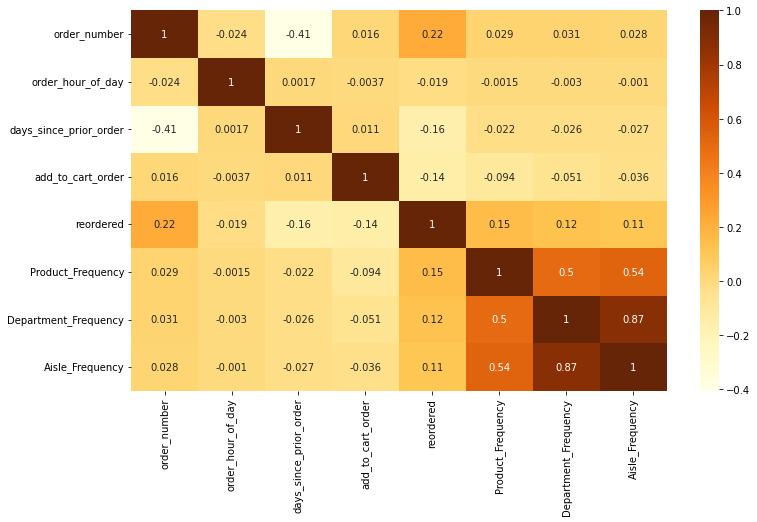

In [1691]:
sns.heatmap(full_orders.select_dtypes(include=["int","float64"]).corr(), cmap="YlOrBr", annot=True)